In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from collections import Counter
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_test(df, test_size):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    X = df.loc[:,'VH_30':'VH_0']
    X['nth'] = df.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [3]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [4]:
kdprov='32'

In [5]:
# Parameters
kdprov = 18


In [6]:
## Read VH dataset
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','rb') as file:
    df=pickle.load(file)
    if isinstance(df, pl.DataFrame):
        df=df.to_pandas()
print(df.shape)
df.head()

(418264, 44)


,idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,...,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance,winner,prior
0,180803002A1#17,180803002A1,180803002,1,2022_03,6,NP,48MWA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1808,2,0.0,R0C0,0.452188
1,180803002A2#12,180803002A2,180803002,1,2022_03,6,NP,48MWA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1808,2,0.0,R0C0,0.452188
2,180803002B2#04,180803002B2,180803002,1,2022_03,6,NP,48MWA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1808,2,0.0,R0C0,0.452188
3,180803002C2#06,180803002C2,180803002,1,2022_03,6,NP,48MWA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1808,2,0.0,R0C0,0.452188
4,180803002C2#15,180803002C2,180803002,1,2022_03,6,NP,48MWA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1808,2,0.0,R0C0,0.452188


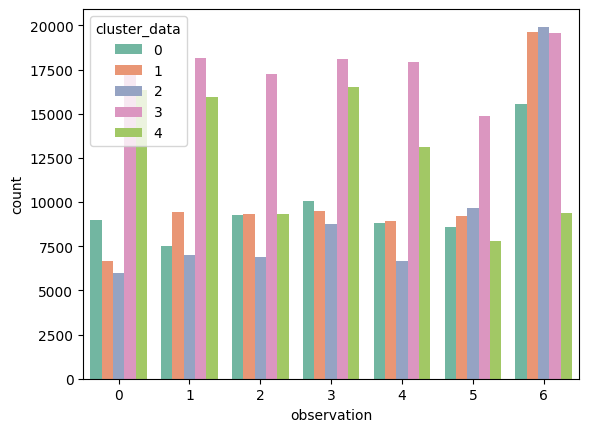

In [7]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')


### Running Data

In [8]:
import optuna
from xgboost import XGBClassifier

# Example dataset

# Define the objective function for Bayesian Optimization
def objective(trial,X_train, y_train, n_splits=3):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        #'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.7),
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 0.7),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
        'objective': 'multi:softprob',  # Multiclass classification
        'eval_metric': ['mlogloss'],
        "tree_method":'hist',
        "num_class": len(set(y_train)),
        "nthread":20
    }
    
    # Define the model
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=42)
    f1_macros=[]
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(param, dtrain_fold, 
                          num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                          verbose_eval=False)
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    score=np.mean(f1_macros)
    
    return score

In [9]:
def evaluate_model(X_train, y_train, X_test, y_test,cluster, best_params, n_splits=3):
    # Convert data to DMatrix for XGBoost
    class_counts = Counter(y_train)
    total_samples = len(y_train)
        # Step 3: Calculate class weights as inverse of class frequency
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = np.array([class_weights[label] for label in y_train])
        # Create DMatrix with sample weights
        
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True,weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    params = best_params
    params['objective']="multi:softprob"
    #params['tree_method']='approx'
    params['eval_metric']='mlogloss'
    params['num_class']=len(set(y_train))
    params['nthread']=20
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(params, dtrain_fold, 
                          num_boost_round=10000, evals=evals,early_stopping_rounds=1000,verbose_eval=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    
    # Final model evaluation on the test set
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, 
                      num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                      verbose_eval=50)
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_cm_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

CLUSTER:  0


[I 2024-10-18 15:58:52,482] A new study created in memory with name: no-name-3e498982-7402-4160-a479-1b8cd73d2f7b


[4 0 6 3 2 5 1]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-18 15:59:20,310] Trial 0 finished with value: 0.8274607851838107 and parameters: {'max_depth': 7, 'learning_rate': 0.06296957380012548, 'reg_lambda': 4.98008810132309, 'min_child_weight': 76}. Best is trial 0 with value: 0.8274607851838107.


[I 2024-10-18 15:59:49,796] Trial 1 finished with value: 0.8286764491831479 and parameters: {'max_depth': 7, 'learning_rate': 0.0608182575073838, 'reg_lambda': 4.9724026651397155, 'min_child_weight': 93}. Best is trial 1 with value: 0.8286764491831479.


[I 2024-10-18 16:00:09,061] Trial 2 finished with value: 0.8275802041914977 and parameters: {'max_depth': 6, 'learning_rate': 0.08652645731475779, 'reg_lambda': 4.604511038312738, 'min_child_weight': 93}. Best is trial 1 with value: 0.8286764491831479.


[I 2024-10-18 16:00:52,840] Trial 3 finished with value: 0.8284173960953077 and parameters: {'max_depth': 7, 'learning_rate': 0.03566531463296035, 'reg_lambda': 1.2938445998018, 'min_child_weight': 93}. Best is trial 1 with value: 0.8286764491831479.


[I 2024-10-18 16:02:05,041] Trial 4 finished with value: 0.8285018017889004 and parameters: {'max_depth': 8, 'learning_rate': 0.022550223369043786, 'reg_lambda': 4.0279294798757475, 'min_child_weight': 66}. Best is trial 1 with value: 0.8286764491831479.


[I 2024-10-18 16:03:18,534] Trial 5 finished with value: 0.829162839434712 and parameters: {'max_depth': 8, 'learning_rate': 0.024108697267927956, 'reg_lambda': 3.837895999429546, 'min_child_weight': 67}. Best is trial 5 with value: 0.829162839434712.


[I 2024-10-18 16:04:25,617] Trial 6 finished with value: 0.8285515114252514 and parameters: {'max_depth': 7, 'learning_rate': 0.024544428788725686, 'reg_lambda': 3.785491368136965, 'min_child_weight': 91}. Best is trial 5 with value: 0.829162839434712.


[I 2024-10-18 16:04:45,694] Trial 7 finished with value: 0.8296337969480607 and parameters: {'max_depth': 10, 'learning_rate': 0.09949014182559474, 'reg_lambda': 2.798449167908198, 'min_child_weight': 88}. Best is trial 7 with value: 0.8296337969480607.


[I 2024-10-18 16:05:06,416] Trial 8 finished with value: 0.8282097132385638 and parameters: {'max_depth': 8, 'learning_rate': 0.07561636655968197, 'reg_lambda': 1.7154297218606953, 'min_child_weight': 52}. Best is trial 7 with value: 0.8296337969480607.


[I 2024-10-18 16:05:26,217] Trial 9 finished with value: 0.8294828795879773 and parameters: {'max_depth': 7, 'learning_rate': 0.06602154313695381, 'reg_lambda': 4.219402337168372, 'min_child_weight': 87}. Best is trial 7 with value: 0.8296337969480607.


[I 2024-10-18 16:05:43,709] Trial 10 finished with value: 0.8302539015830916 and parameters: {'max_depth': 10, 'learning_rate': 0.09904691634651121, 'reg_lambda': 0.13360076634980222, 'min_child_weight': 81}. Best is trial 10 with value: 0.8302539015830916.


[I 2024-10-18 16:06:05,647] Trial 11 finished with value: 0.8286563970585242 and parameters: {'max_depth': 10, 'learning_rate': 0.09966838308658932, 'reg_lambda': 0.30110177001323857, 'min_child_weight': 79}. Best is trial 10 with value: 0.8302539015830916.


[I 2024-10-18 16:06:27,217] Trial 12 finished with value: 0.8317762643602017 and parameters: {'max_depth': 10, 'learning_rate': 0.09299325372390269, 'reg_lambda': 2.7805120367372633, 'min_child_weight': 83}. Best is trial 12 with value: 0.8317762643602017.


[I 2024-10-18 16:06:50,510] Trial 13 finished with value: 0.8297010708078251 and parameters: {'max_depth': 9, 'learning_rate': 0.08460761837298565, 'reg_lambda': 2.711037527044465, 'min_child_weight': 81}. Best is trial 12 with value: 0.8317762643602017.


[I 2024-10-18 16:07:32,644] Trial 14 finished with value: 0.8298009733812509 and parameters: {'max_depth': 10, 'learning_rate': 0.0479849040268059, 'reg_lambda': 1.8070508255728543, 'min_child_weight': 67}. Best is trial 12 with value: 0.8317762643602017.


[I 2024-10-18 16:07:54,960] Trial 15 finished with value: 0.8298183366221524 and parameters: {'max_depth': 9, 'learning_rate': 0.08835184415933489, 'reg_lambda': 0.1671502422861817, 'min_child_weight': 100}. Best is trial 12 with value: 0.8317762643602017.


[I 2024-10-18 16:08:18,451] Trial 16 finished with value: 0.829906738364623 and parameters: {'max_depth': 9, 'learning_rate': 0.07699938565004014, 'reg_lambda': 3.2488855646598953, 'min_child_weight': 83}. Best is trial 12 with value: 0.8317762643602017.


[I 2024-10-18 16:08:59,168] Trial 17 finished with value: 0.8295165117143074 and parameters: {'max_depth': 10, 'learning_rate': 0.04450756057639375, 'reg_lambda': 1.1660518442947518, 'min_child_weight': 72}. Best is trial 12 with value: 0.8317762643602017.


[I 2024-10-18 16:09:18,822] Trial 18 finished with value: 0.8302958724535774 and parameters: {'max_depth': 9, 'learning_rate': 0.09280454800454346, 'reg_lambda': 2.1814955655938997, 'min_child_weight': 57}. Best is trial 12 with value: 0.8317762643602017.


[I 2024-10-18 16:09:42,278] Trial 19 finished with value: 0.8312076385799895 and parameters: {'max_depth': 9, 'learning_rate': 0.07785039382616973, 'reg_lambda': 3.2361344148947597, 'min_child_weight': 52}. Best is trial 12 with value: 0.8317762643602017.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.09299325372390269, 'reg_lambda': 2.7805120367372633, 'min_child_weight': 83}
Best Score: 0.8317762643602017
Start the modelling


[0]	train-mlogloss:1.75777	eval-mlogloss:1.76540


[100]	train-mlogloss:0.17315	eval-mlogloss:0.48537


[200]	train-mlogloss:0.09564	eval-mlogloss:0.48053


[300]	train-mlogloss:0.06303	eval-mlogloss:0.48925


[400]	train-mlogloss:0.04629	eval-mlogloss:0.49929


[500]	train-mlogloss:0.03668	eval-mlogloss:0.51005


[600]	train-mlogloss:0.03066	eval-mlogloss:0.51954


[700]	train-mlogloss:0.02620	eval-mlogloss:0.52921


[800]	train-mlogloss:0.02312	eval-mlogloss:0.53756


[900]	train-mlogloss:0.02067	eval-mlogloss:0.54491


[1000]	train-mlogloss:0.01878	eval-mlogloss:0.55161


[1100]	train-mlogloss:0.01731	eval-mlogloss:0.55747


[1173]	train-mlogloss:0.01640	eval-mlogloss:0.56166


[0]	train-mlogloss:1.76205	eval-mlogloss:1.76998


[100]	train-mlogloss:0.17275	eval-mlogloss:0.46794


[200]	train-mlogloss:0.09435	eval-mlogloss:0.46457


[300]	train-mlogloss:0.06286	eval-mlogloss:0.47166


[400]	train-mlogloss:0.04633	eval-mlogloss:0.48213


[500]	train-mlogloss:0.03682	eval-mlogloss:0.49238


[600]	train-mlogloss:0.03054	eval-mlogloss:0.50159


[700]	train-mlogloss:0.02635	eval-mlogloss:0.50893


[800]	train-mlogloss:0.02318	eval-mlogloss:0.51605


[900]	train-mlogloss:0.02085	eval-mlogloss:0.52262


[1000]	train-mlogloss:0.01899	eval-mlogloss:0.52877


[1100]	train-mlogloss:0.01750	eval-mlogloss:0.53431


[1153]	train-mlogloss:0.01683	eval-mlogloss:0.53690


[0]	train-mlogloss:1.75909	eval-mlogloss:1.76618


[100]	train-mlogloss:0.17659	eval-mlogloss:0.47242


[200]	train-mlogloss:0.09469	eval-mlogloss:0.46832


[300]	train-mlogloss:0.06273	eval-mlogloss:0.47539


[400]	train-mlogloss:0.04590	eval-mlogloss:0.48504


[500]	train-mlogloss:0.03642	eval-mlogloss:0.49663


[600]	train-mlogloss:0.03048	eval-mlogloss:0.50582


[700]	train-mlogloss:0.02618	eval-mlogloss:0.51385


[800]	train-mlogloss:0.02305	eval-mlogloss:0.52078


[900]	train-mlogloss:0.02071	eval-mlogloss:0.52718


[1000]	train-mlogloss:0.01888	eval-mlogloss:0.53324


[1100]	train-mlogloss:0.01738	eval-mlogloss:0.53861


[1156]	train-mlogloss:0.01665	eval-mlogloss:0.54163


[0]	train-mlogloss:1.75514	eval-mlogloss:1.76165


[50]	train-mlogloss:0.30743	eval-mlogloss:0.50370


[100]	train-mlogloss:0.18852	eval-mlogloss:0.45784


[150]	train-mlogloss:0.13722	eval-mlogloss:0.45138


[200]	train-mlogloss:0.10670	eval-mlogloss:0.45148


[227]	train-mlogloss:0.09463	eval-mlogloss:0.45249



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      6293
           1       0.88      0.84      0.86      5279
           2       0.73      0.70      0.71      6501
           3       0.91      0.94      0.92      7040
           4       0.84      0.75      0.79      6177
           5       0.72      0.69      0.70      5994
           6       0.91      0.99      0.95     10882

    accuracy                           0.85     48166
   macro avg       0.84      0.83      0.84     48166
weighted avg       0.85      0.85      0.85     48166



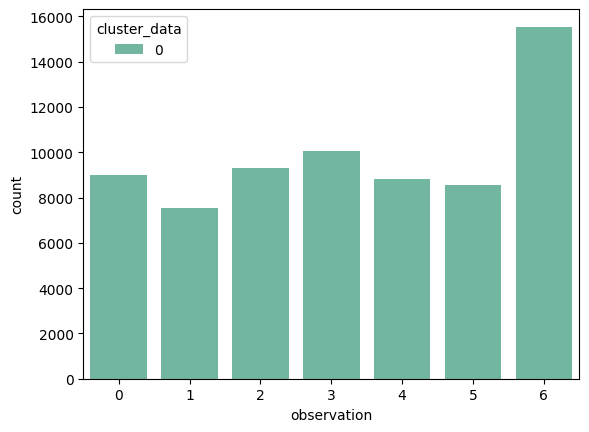

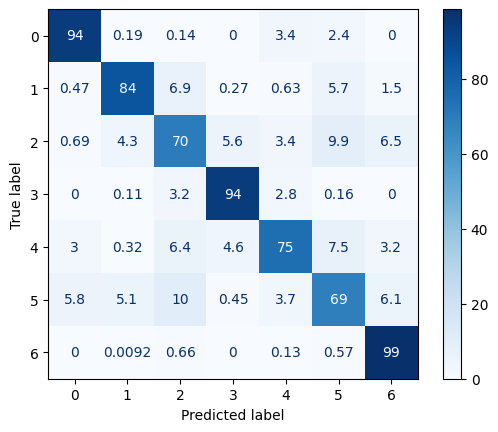

{'average_accuracy': 0.8436198810002602, 'average_f1_macro': 0.8288149575622473, 'average_f1_micro': 0.8436198810002602, 'average_auc': 0.969972191290613, 'average_acc_kelas_generatif': 0.9353665733624785, 'average_acc_fase_padi': 0.8066653227145428}
{'val_accuracy': 0.8505377237055184, 'val_f1_macro': 0.8363910532805743, 'val_f1_micro': 0.8505377237055184, 'val_auc': 0.9728654924137465, 'val_acc_kelas_generatif': 0.9372159090909091, 'val_acc_fase_padi': 0.8087770532463896, 'val_relative_acc': 93.18398799781778}
CLUSTER:  1


[I 2024-10-18 16:11:13,607] A new study created in memory with name: no-name-98522c2b-8eb8-4b79-a5dd-d9c5d12132f3


[4 3 6 1 2 5 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-18 16:11:31,095] Trial 0 finished with value: 0.42078120747782694 and parameters: {'max_depth': 9, 'learning_rate': 0.07091700296512121, 'reg_lambda': 3.7312266527892217, 'min_child_weight': 81}. Best is trial 0 with value: 0.42078120747782694.


[I 2024-10-18 16:11:51,207] Trial 1 finished with value: 0.422800629351266 and parameters: {'max_depth': 10, 'learning_rate': 0.06899485084617167, 'reg_lambda': 3.3093038843099705, 'min_child_weight': 60}. Best is trial 1 with value: 0.422800629351266.


[I 2024-10-18 16:12:13,503] Trial 2 finished with value: 0.4244984133175646 and parameters: {'max_depth': 9, 'learning_rate': 0.05938736452216968, 'reg_lambda': 1.7840528227431653, 'min_child_weight': 60}. Best is trial 2 with value: 0.4244984133175646.


[I 2024-10-18 16:13:21,873] Trial 3 finished with value: 0.41899809267305893 and parameters: {'max_depth': 7, 'learning_rate': 0.013713274147393081, 'reg_lambda': 2.344906582151532, 'min_child_weight': 69}. Best is trial 2 with value: 0.4244984133175646.


[I 2024-10-18 16:14:02,516] Trial 4 finished with value: 0.419553048502661 and parameters: {'max_depth': 8, 'learning_rate': 0.022765937565971853, 'reg_lambda': 0.4239896268032647, 'min_child_weight': 87}. Best is trial 2 with value: 0.4244984133175646.


[I 2024-10-18 16:14:25,843] Trial 5 finished with value: 0.4202784179158166 and parameters: {'max_depth': 8, 'learning_rate': 0.04218124715519516, 'reg_lambda': 2.0383688029645572, 'min_child_weight': 90}. Best is trial 2 with value: 0.4244984133175646.


[I 2024-10-18 16:14:41,498] Trial 6 finished with value: 0.42079850911265754 and parameters: {'max_depth': 9, 'learning_rate': 0.07417830118076155, 'reg_lambda': 3.5138694881790626, 'min_child_weight': 95}. Best is trial 2 with value: 0.4244984133175646.


[I 2024-10-18 16:15:35,218] Trial 7 finished with value: 0.4245669830213325 and parameters: {'max_depth': 8, 'learning_rate': 0.021407381267521414, 'reg_lambda': 3.391288051599701, 'min_child_weight': 58}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:16:51,636] Trial 8 finished with value: 0.4219590637617316 and parameters: {'max_depth': 7, 'learning_rate': 0.014581194079912208, 'reg_lambda': 4.165207998547118, 'min_child_weight': 89}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:17:21,269] Trial 9 finished with value: 0.4194761143009633 and parameters: {'max_depth': 8, 'learning_rate': 0.0368461018216975, 'reg_lambda': 3.6783439071075352, 'min_child_weight': 95}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:17:33,590] Trial 10 finished with value: 0.42088867705948846 and parameters: {'max_depth': 6, 'learning_rate': 0.095272716736994, 'reg_lambda': 4.982759038124339, 'min_child_weight': 51}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:17:52,043] Trial 11 finished with value: 0.4228606182691694 and parameters: {'max_depth': 10, 'learning_rate': 0.052897793551981896, 'reg_lambda': 1.3443737498339194, 'min_child_weight': 66}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:18:23,134] Trial 12 finished with value: 0.4227218384571796 and parameters: {'max_depth': 9, 'learning_rate': 0.036445542165268685, 'reg_lambda': 1.4256032519130075, 'min_child_weight': 50}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:18:46,985] Trial 13 finished with value: 0.4232790016698609 and parameters: {'max_depth': 7, 'learning_rate': 0.05618301925453695, 'reg_lambda': 2.761937682003035, 'min_child_weight': 59}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:19:01,740] Trial 14 finished with value: 0.42241711775961127 and parameters: {'max_depth': 9, 'learning_rate': 0.08874796390183683, 'reg_lambda': 1.5361593141640248, 'min_child_weight': 73}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:19:25,536] Trial 15 finished with value: 0.4234051068938924 and parameters: {'max_depth': 8, 'learning_rate': 0.0555971481781036, 'reg_lambda': 0.5964390112504239, 'min_child_weight': 61}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:20:07,737] Trial 16 finished with value: 0.42290418160267523 and parameters: {'max_depth': 10, 'learning_rate': 0.02749776390281876, 'reg_lambda': 2.9586757540743487, 'min_child_weight': 55}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:20:25,288] Trial 17 finished with value: 0.4211475964780765 and parameters: {'max_depth': 6, 'learning_rate': 0.08319407359658818, 'reg_lambda': 4.425596330740019, 'min_child_weight': 66}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:20:51,834] Trial 18 finished with value: 0.4199457858449754 and parameters: {'max_depth': 9, 'learning_rate': 0.04973975314677985, 'reg_lambda': 2.0377573089416314, 'min_child_weight': 78}. Best is trial 7 with value: 0.4245669830213325.


[I 2024-10-18 16:21:12,613] Trial 19 finished with value: 0.42120427249740633 and parameters: {'max_depth': 7, 'learning_rate': 0.06023341170705017, 'reg_lambda': 0.8194911853975047, 'min_child_weight': 56}. Best is trial 7 with value: 0.4245669830213325.


Best Parameters: {'max_depth': 8, 'learning_rate': 0.021407381267521414, 'reg_lambda': 3.391288051599701, 'min_child_weight': 58}
Best Score: 0.4245669830213325
Start the modelling


[0]	train-mlogloss:1.92915	eval-mlogloss:1.93416


[100]	train-mlogloss:1.33419	eval-mlogloss:1.56269


[200]	train-mlogloss:1.18774	eval-mlogloss:1.51210


[300]	train-mlogloss:1.10731	eval-mlogloss:1.50058


[400]	train-mlogloss:1.05085	eval-mlogloss:1.49794


[500]	train-mlogloss:1.00112	eval-mlogloss:1.49618


[600]	train-mlogloss:0.96181	eval-mlogloss:1.49628


[700]	train-mlogloss:0.92466	eval-mlogloss:1.49707


[800]	train-mlogloss:0.89258	eval-mlogloss:1.49805


[900]	train-mlogloss:0.86215	eval-mlogloss:1.49956


[1000]	train-mlogloss:0.83577	eval-mlogloss:1.50130


[1100]	train-mlogloss:0.81218	eval-mlogloss:1.50395


[1200]	train-mlogloss:0.79026	eval-mlogloss:1.50693


[1300]	train-mlogloss:0.76919	eval-mlogloss:1.50945


[1400]	train-mlogloss:0.75115	eval-mlogloss:1.51191


[1500]	train-mlogloss:0.73337	eval-mlogloss:1.51512


[1535]	train-mlogloss:0.72842	eval-mlogloss:1.51600


[0]	train-mlogloss:1.92889	eval-mlogloss:1.93371


[100]	train-mlogloss:1.32807	eval-mlogloss:1.56252


[200]	train-mlogloss:1.18000	eval-mlogloss:1.51407


[300]	train-mlogloss:1.10589	eval-mlogloss:1.50331


[400]	train-mlogloss:1.05222	eval-mlogloss:1.50093


[500]	train-mlogloss:1.00589	eval-mlogloss:1.49947


[600]	train-mlogloss:0.96768	eval-mlogloss:1.50017


[700]	train-mlogloss:0.93426	eval-mlogloss:1.50132


[800]	train-mlogloss:0.90159	eval-mlogloss:1.50323


[900]	train-mlogloss:0.86923	eval-mlogloss:1.50479


[1000]	train-mlogloss:0.84237	eval-mlogloss:1.50694


[1100]	train-mlogloss:0.81821	eval-mlogloss:1.50941


[1200]	train-mlogloss:0.79837	eval-mlogloss:1.51118


[1300]	train-mlogloss:0.77781	eval-mlogloss:1.51375


[1400]	train-mlogloss:0.75907	eval-mlogloss:1.51660


[1500]	train-mlogloss:0.74322	eval-mlogloss:1.51926


[1501]	train-mlogloss:0.74302	eval-mlogloss:1.51930


[0]	train-mlogloss:1.92874	eval-mlogloss:1.93416


[100]	train-mlogloss:1.33331	eval-mlogloss:1.56440


[200]	train-mlogloss:1.18048	eval-mlogloss:1.51587


[300]	train-mlogloss:1.10277	eval-mlogloss:1.50538


[400]	train-mlogloss:1.04618	eval-mlogloss:1.50090


[500]	train-mlogloss:0.99905	eval-mlogloss:1.49934


[600]	train-mlogloss:0.95471	eval-mlogloss:1.49897


[700]	train-mlogloss:0.91850	eval-mlogloss:1.49985


[800]	train-mlogloss:0.88621	eval-mlogloss:1.50110


[900]	train-mlogloss:0.85870	eval-mlogloss:1.50303


[1000]	train-mlogloss:0.83372	eval-mlogloss:1.50543


[1100]	train-mlogloss:0.81238	eval-mlogloss:1.50751


[1200]	train-mlogloss:0.79170	eval-mlogloss:1.50955


[1300]	train-mlogloss:0.77465	eval-mlogloss:1.51180


[1400]	train-mlogloss:0.75679	eval-mlogloss:1.51451


[1500]	train-mlogloss:0.73936	eval-mlogloss:1.51669


[1600]	train-mlogloss:0.72396	eval-mlogloss:1.51906


[1624]	train-mlogloss:0.72043	eval-mlogloss:1.51974


[0]	train-mlogloss:1.92916	eval-mlogloss:1.93348


[50]	train-mlogloss:1.51562	eval-mlogloss:1.63981


[100]	train-mlogloss:1.35998	eval-mlogloss:1.54864


[150]	train-mlogloss:1.27529	eval-mlogloss:1.51209


[200]	train-mlogloss:1.22148	eval-mlogloss:1.49566


[250]	train-mlogloss:1.18169	eval-mlogloss:1.48563


[300]	train-mlogloss:1.15195	eval-mlogloss:1.47993


[350]	train-mlogloss:1.12641	eval-mlogloss:1.47649


[400]	train-mlogloss:1.10131	eval-mlogloss:1.47373


[450]	train-mlogloss:1.07921	eval-mlogloss:1.47219


[500]	train-mlogloss:1.05764	eval-mlogloss:1.47093


[550]	train-mlogloss:1.03806	eval-mlogloss:1.46994


[600]	train-mlogloss:1.02063	eval-mlogloss:1.46938


[650]	train-mlogloss:1.00463	eval-mlogloss:1.46909


[700]	train-mlogloss:0.98888	eval-mlogloss:1.46909


[716]	train-mlogloss:0.98463	eval-mlogloss:1.46908



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.82      0.64      0.72      4660
           1       0.35      0.31      0.33      6592
           2       0.36      0.47      0.41      6509
           3       0.35      0.39      0.37      6653
           4       0.37      0.41      0.39      6231
           5       0.37      0.42      0.39      6463
           6       0.47      0.39      0.42     13753

    accuracy                           0.42     50861
   macro avg       0.44      0.43      0.43     50861
weighted avg       0.43      0.42      0.42     50861



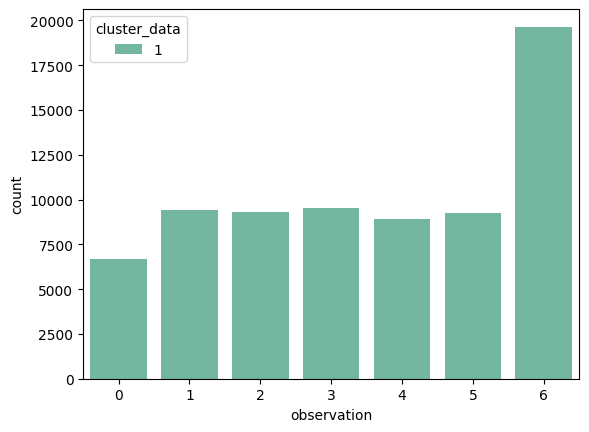

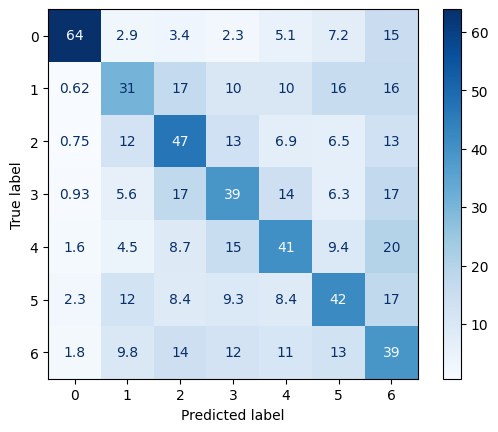

{'average_accuracy': 0.4143232231727631, 'average_f1_macro': 0.4250765773934959, 'average_f1_micro': 0.4143232231727631, 'average_auc': 0.778552077239873, 'average_acc_kelas_generatif': 0.3746128728761968, 'average_acc_fase_padi': 0.37625718390804597}
{'val_accuracy': 0.41701893395725603, 'val_f1_macro': 0.4320359288164636, 'val_f1_micro': 0.41701893395725603, 'val_auc': 0.7929631295793149, 'val_acc_kelas_generatif': 0.3868931309183827, 'val_acc_fase_padi': 0.3918414469886473, 'val_relative_acc': 81.33938961672736}
CLUSTER:  2


[I 2024-10-18 16:23:30,828] A new study created in memory with name: no-name-4c928843-95e7-4ff1-8ac7-172d7dd4b7a8


[6 2 5 0 3 4 1]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-18 16:23:45,067] Trial 0 finished with value: 0.7910076103382314 and parameters: {'max_depth': 9, 'learning_rate': 0.08970254897856103, 'reg_lambda': 3.776165017166907, 'min_child_weight': 54}. Best is trial 0 with value: 0.7910076103382314.


[I 2024-10-18 16:24:34,140] Trial 1 finished with value: 0.7923979085311359 and parameters: {'max_depth': 8, 'learning_rate': 0.02231269475410643, 'reg_lambda': 1.5590685186687128, 'min_child_weight': 66}. Best is trial 1 with value: 0.7923979085311359.


[I 2024-10-18 16:25:51,546] Trial 2 finished with value: 0.7923409394549269 and parameters: {'max_depth': 8, 'learning_rate': 0.016287549421291424, 'reg_lambda': 4.2295236708093835, 'min_child_weight': 88}. Best is trial 1 with value: 0.7923979085311359.


[I 2024-10-18 16:26:17,950] Trial 3 finished with value: 0.7898785759080198 and parameters: {'max_depth': 9, 'learning_rate': 0.051393965698351925, 'reg_lambda': 2.8707693101644822, 'min_child_weight': 82}. Best is trial 1 with value: 0.7923979085311359.


[I 2024-10-18 16:26:32,379] Trial 4 finished with value: 0.7899784386685097 and parameters: {'max_depth': 7, 'learning_rate': 0.08734489755315883, 'reg_lambda': 0.8090178376217523, 'min_child_weight': 66}. Best is trial 1 with value: 0.7923979085311359.


[I 2024-10-18 16:27:04,957] Trial 5 finished with value: 0.7896749852458953 and parameters: {'max_depth': 8, 'learning_rate': 0.03833796387513729, 'reg_lambda': 1.7845360607446534, 'min_child_weight': 96}. Best is trial 1 with value: 0.7923979085311359.


[I 2024-10-18 16:27:24,490] Trial 6 finished with value: 0.790210393774858 and parameters: {'max_depth': 8, 'learning_rate': 0.06628933359649809, 'reg_lambda': 2.2361806531824597, 'min_child_weight': 59}. Best is trial 1 with value: 0.7923979085311359.


[I 2024-10-18 16:28:02,090] Trial 7 finished with value: 0.7896547217524889 and parameters: {'max_depth': 9, 'learning_rate': 0.03140994201578299, 'reg_lambda': 4.168748823783808, 'min_child_weight': 75}. Best is trial 1 with value: 0.7923979085311359.


[I 2024-10-18 16:28:47,838] Trial 8 finished with value: 0.7892327203790748 and parameters: {'max_depth': 9, 'learning_rate': 0.019993645690579806, 'reg_lambda': 1.5951934143979811, 'min_child_weight': 63}. Best is trial 1 with value: 0.7923979085311359.


[I 2024-10-18 16:29:04,541] Trial 9 finished with value: 0.789445487481904 and parameters: {'max_depth': 8, 'learning_rate': 0.07693717824722433, 'reg_lambda': 3.36483486348628, 'min_child_weight': 95}. Best is trial 1 with value: 0.7923979085311359.


[I 2024-10-18 16:29:31,643] Trial 10 finished with value: 0.7930708013952626 and parameters: {'max_depth': 6, 'learning_rate': 0.04668771942572982, 'reg_lambda': 0.29150875231976725, 'min_child_weight': 73}. Best is trial 10 with value: 0.7930708013952626.


[I 2024-10-18 16:30:08,122] Trial 11 finished with value: 0.7927617271218278 and parameters: {'max_depth': 6, 'learning_rate': 0.04684741674177642, 'reg_lambda': 0.11684954818874796, 'min_child_weight': 72}. Best is trial 10 with value: 0.7930708013952626.


[I 2024-10-18 16:30:32,893] Trial 12 finished with value: 0.790758589621051 and parameters: {'max_depth': 6, 'learning_rate': 0.05328228407421949, 'reg_lambda': 0.2186255074370571, 'min_child_weight': 73}. Best is trial 10 with value: 0.7930708013952626.


[I 2024-10-18 16:31:03,895] Trial 13 finished with value: 0.7929749122647539 and parameters: {'max_depth': 6, 'learning_rate': 0.04018237045654404, 'reg_lambda': 0.10420104560527109, 'min_child_weight': 82}. Best is trial 10 with value: 0.7930708013952626.


[I 2024-10-18 16:31:25,109] Trial 14 finished with value: 0.7905162608362349 and parameters: {'max_depth': 7, 'learning_rate': 0.06648268540451459, 'reg_lambda': 0.9031021436143514, 'min_child_weight': 83}. Best is trial 10 with value: 0.7930708013952626.


[I 2024-10-18 16:31:57,789] Trial 15 finished with value: 0.7898933521507301 and parameters: {'max_depth': 6, 'learning_rate': 0.03971537968714153, 'reg_lambda': 0.889753611657564, 'min_child_weight': 82}. Best is trial 10 with value: 0.7930708013952626.


[I 2024-10-18 16:32:18,231] Trial 16 finished with value: 0.7909627955084361 and parameters: {'max_depth': 7, 'learning_rate': 0.06532804767848405, 'reg_lambda': 0.5897078307565548, 'min_child_weight': 87}. Best is trial 10 with value: 0.7930708013952626.


[I 2024-10-18 16:33:03,444] Trial 17 finished with value: 0.7889151718531947 and parameters: {'max_depth': 10, 'learning_rate': 0.02751186709403481, 'reg_lambda': 4.908201432710715, 'min_child_weight': 78}. Best is trial 10 with value: 0.7930708013952626.


[I 2024-10-18 16:33:56,718] Trial 18 finished with value: 0.7938499381783694 and parameters: {'max_depth': 6, 'learning_rate': 0.011104751955179286, 'reg_lambda': 1.1945315776332817, 'min_child_weight': 88}. Best is trial 18 with value: 0.7938499381783694.


[I 2024-10-18 16:35:03,486] Trial 19 finished with value: 0.7941674617461921 and parameters: {'max_depth': 7, 'learning_rate': 0.011981231262808797, 'reg_lambda': 1.2572492597705718, 'min_child_weight': 90}. Best is trial 19 with value: 0.7941674617461921.


Best Parameters: {'max_depth': 7, 'learning_rate': 0.011981231262808797, 'reg_lambda': 1.2572492597705718, 'min_child_weight': 90}
Best Score: 0.7941674617461921
Start the modelling


[0]	train-mlogloss:1.92068	eval-mlogloss:1.92363


[100]	train-mlogloss:0.91676	eval-mlogloss:1.01694


[200]	train-mlogloss:0.65084	eval-mlogloss:0.78323


[300]	train-mlogloss:0.54631	eval-mlogloss:0.69735


[400]	train-mlogloss:0.49580	eval-mlogloss:0.66116


[500]	train-mlogloss:0.46540	eval-mlogloss:0.64279


[600]	train-mlogloss:0.44483	eval-mlogloss:0.63230


[700]	train-mlogloss:0.43077	eval-mlogloss:0.62619


[800]	train-mlogloss:0.41999	eval-mlogloss:0.62248


[900]	train-mlogloss:0.41164	eval-mlogloss:0.62009


[1000]	train-mlogloss:0.40449	eval-mlogloss:0.61838


[1100]	train-mlogloss:0.39802	eval-mlogloss:0.61731


[1200]	train-mlogloss:0.39261	eval-mlogloss:0.61656


[1300]	train-mlogloss:0.38785	eval-mlogloss:0.61610


[1400]	train-mlogloss:0.38337	eval-mlogloss:0.61576


[1500]	train-mlogloss:0.37951	eval-mlogloss:0.61571


[1600]	train-mlogloss:0.37626	eval-mlogloss:0.61578


[1700]	train-mlogloss:0.37338	eval-mlogloss:0.61596


[1800]	train-mlogloss:0.37074	eval-mlogloss:0.61591


[1900]	train-mlogloss:0.36821	eval-mlogloss:0.61619


[2000]	train-mlogloss:0.36573	eval-mlogloss:0.61636


[2100]	train-mlogloss:0.36369	eval-mlogloss:0.61674


[2200]	train-mlogloss:0.36169	eval-mlogloss:0.61718


[2300]	train-mlogloss:0.35974	eval-mlogloss:0.61761


[2400]	train-mlogloss:0.35795	eval-mlogloss:0.61845


[2500]	train-mlogloss:0.35625	eval-mlogloss:0.61918


[2546]	train-mlogloss:0.35560	eval-mlogloss:0.61936


[0]	train-mlogloss:1.92081	eval-mlogloss:1.92358


[100]	train-mlogloss:0.91427	eval-mlogloss:1.01437


[200]	train-mlogloss:0.64662	eval-mlogloss:0.77792


[300]	train-mlogloss:0.54082	eval-mlogloss:0.69079


[400]	train-mlogloss:0.48907	eval-mlogloss:0.65388


[500]	train-mlogloss:0.45865	eval-mlogloss:0.63559


[600]	train-mlogloss:0.43786	eval-mlogloss:0.62562


[700]	train-mlogloss:0.42306	eval-mlogloss:0.62037


[800]	train-mlogloss:0.41184	eval-mlogloss:0.61769


[900]	train-mlogloss:0.40260	eval-mlogloss:0.61572


[1000]	train-mlogloss:0.39470	eval-mlogloss:0.61433


[1100]	train-mlogloss:0.38770	eval-mlogloss:0.61356


[1200]	train-mlogloss:0.38178	eval-mlogloss:0.61285


[1300]	train-mlogloss:0.37679	eval-mlogloss:0.61238


[1400]	train-mlogloss:0.37214	eval-mlogloss:0.61242


[1500]	train-mlogloss:0.36824	eval-mlogloss:0.61247


[1600]	train-mlogloss:0.36484	eval-mlogloss:0.61269


[1700]	train-mlogloss:0.36192	eval-mlogloss:0.61297


[1800]	train-mlogloss:0.35886	eval-mlogloss:0.61324


[1900]	train-mlogloss:0.35610	eval-mlogloss:0.61352


[2000]	train-mlogloss:0.35376	eval-mlogloss:0.61386


[2100]	train-mlogloss:0.35161	eval-mlogloss:0.61413


[2200]	train-mlogloss:0.34974	eval-mlogloss:0.61442


[2300]	train-mlogloss:0.34775	eval-mlogloss:0.61501


[2331]	train-mlogloss:0.34710	eval-mlogloss:0.61522


[0]	train-mlogloss:1.92089	eval-mlogloss:1.92363


[100]	train-mlogloss:0.91681	eval-mlogloss:1.01759


[200]	train-mlogloss:0.65144	eval-mlogloss:0.78231


[300]	train-mlogloss:0.54613	eval-mlogloss:0.69454


[400]	train-mlogloss:0.49455	eval-mlogloss:0.65691


[500]	train-mlogloss:0.46433	eval-mlogloss:0.63741


[600]	train-mlogloss:0.44498	eval-mlogloss:0.62662


[700]	train-mlogloss:0.43059	eval-mlogloss:0.62081


[800]	train-mlogloss:0.41999	eval-mlogloss:0.61738


[900]	train-mlogloss:0.41030	eval-mlogloss:0.61462


[1000]	train-mlogloss:0.40256	eval-mlogloss:0.61288


[1100]	train-mlogloss:0.39598	eval-mlogloss:0.61170


[1200]	train-mlogloss:0.39002	eval-mlogloss:0.61132


[1300]	train-mlogloss:0.38537	eval-mlogloss:0.61114


[1400]	train-mlogloss:0.38131	eval-mlogloss:0.61127


[1500]	train-mlogloss:0.37737	eval-mlogloss:0.61130


[1600]	train-mlogloss:0.37392	eval-mlogloss:0.61128


[1700]	train-mlogloss:0.37084	eval-mlogloss:0.61128


[1800]	train-mlogloss:0.36807	eval-mlogloss:0.61156


[1900]	train-mlogloss:0.36550	eval-mlogloss:0.61191


[2000]	train-mlogloss:0.36309	eval-mlogloss:0.61235


[2100]	train-mlogloss:0.36110	eval-mlogloss:0.61296


[2200]	train-mlogloss:0.35913	eval-mlogloss:0.61341


[2300]	train-mlogloss:0.35727	eval-mlogloss:0.61399


[2350]	train-mlogloss:0.35643	eval-mlogloss:0.61429


[0]	train-mlogloss:1.92057	eval-mlogloss:1.92319


[50]	train-mlogloss:1.21726	eval-mlogloss:1.28287


[100]	train-mlogloss:0.91554	eval-mlogloss:1.00676


[150]	train-mlogloss:0.74975	eval-mlogloss:0.85763


[200]	train-mlogloss:0.65122	eval-mlogloss:0.77093


[250]	train-mlogloss:0.58766	eval-mlogloss:0.71726


[300]	train-mlogloss:0.54674	eval-mlogloss:0.68373


[350]	train-mlogloss:0.51848	eval-mlogloss:0.66214


[400]	train-mlogloss:0.49746	eval-mlogloss:0.64728


[450]	train-mlogloss:0.48105	eval-mlogloss:0.63645


[500]	train-mlogloss:0.46816	eval-mlogloss:0.62891


[550]	train-mlogloss:0.45765	eval-mlogloss:0.62294


[600]	train-mlogloss:0.44904	eval-mlogloss:0.61883


[650]	train-mlogloss:0.44169	eval-mlogloss:0.61562


[700]	train-mlogloss:0.43529	eval-mlogloss:0.61312


[750]	train-mlogloss:0.42995	eval-mlogloss:0.61129


[800]	train-mlogloss:0.42507	eval-mlogloss:0.60971


[850]	train-mlogloss:0.42069	eval-mlogloss:0.60836


[900]	train-mlogloss:0.41684	eval-mlogloss:0.60736


[950]	train-mlogloss:0.41330	eval-mlogloss:0.60637


[999]	train-mlogloss:0.40958	eval-mlogloss:0.60541



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      4170
           1       0.92      0.97      0.95      4897
           2       0.86      0.67      0.76      4805
           3       0.95      0.96      0.95      6148
           4       0.87      0.74      0.80      4653
           5       0.50      0.61      0.55      6761
           6       0.73      0.74      0.74     13948

    accuracy                           0.78     45382
   macro avg       0.82      0.79      0.80     45382
weighted avg       0.79      0.78      0.78     45382



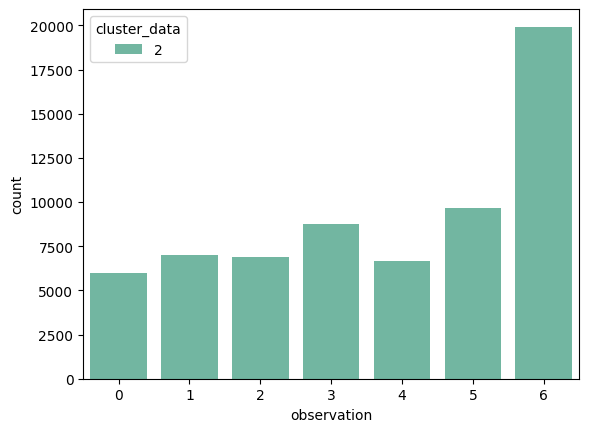

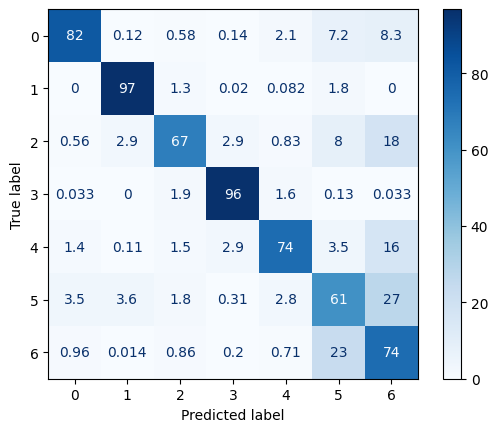

{'average_accuracy': 0.7705794642398067, 'average_f1_macro': 0.7901476818607449, 'average_f1_micro': 0.7705794642398067, 'average_auc': 0.9505252974425806, 'average_acc_kelas_generatif': 0.9612907433466104, 'average_acc_fase_padi': 0.8471605781267783}
{'val_accuracy': 0.7761667621523952, 'val_f1_macro': 0.798398670990688, 'val_f1_micro': 0.7761667621523952, 'val_auc': 0.9525928087365199, 'val_acc_kelas_generatif': 0.9627521145087834, 'val_acc_fase_padi': 0.8461688533385359, 'val_relative_acc': 97.21654749744637}
CLUSTER:  3


[I 2024-10-18 16:38:15,300] A new study created in memory with name: no-name-e0aa6c3e-5a91-4a84-818e-855c59c76cf0


[1 6 2 3 5 0 4]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-18 16:39:19,907] Trial 0 finished with value: 0.9369428124230123 and parameters: {'max_depth': 9, 'learning_rate': 0.03533720372181492, 'reg_lambda': 3.2862289095038917, 'min_child_weight': 98}. Best is trial 0 with value: 0.9369428124230123.


[I 2024-10-18 16:40:06,887] Trial 1 finished with value: 0.9368944877489035 and parameters: {'max_depth': 10, 'learning_rate': 0.0682567052498242, 'reg_lambda': 0.2178328483800155, 'min_child_weight': 68}. Best is trial 0 with value: 0.9369428124230123.


[I 2024-10-18 16:41:12,745] Trial 2 finished with value: 0.937096850109335 and parameters: {'max_depth': 7, 'learning_rate': 0.04247214154168514, 'reg_lambda': 2.7038095584420994, 'min_child_weight': 58}. Best is trial 2 with value: 0.937096850109335.


[I 2024-10-18 16:41:52,356] Trial 3 finished with value: 0.9378463796769738 and parameters: {'max_depth': 7, 'learning_rate': 0.0828085650449572, 'reg_lambda': 2.6890203811461575, 'min_child_weight': 50}. Best is trial 3 with value: 0.9378463796769738.


[I 2024-10-18 16:42:26,515] Trial 4 finished with value: 0.9372524109519901 and parameters: {'max_depth': 7, 'learning_rate': 0.09352737325004552, 'reg_lambda': 3.3787721076618227, 'min_child_weight': 88}. Best is trial 3 with value: 0.9378463796769738.


[I 2024-10-18 16:43:50,363] Trial 5 finished with value: 0.936977936402091 and parameters: {'max_depth': 8, 'learning_rate': 0.030262681931088616, 'reg_lambda': 2.432217312970222, 'min_child_weight': 57}. Best is trial 3 with value: 0.9378463796769738.


[I 2024-10-18 16:44:38,581] Trial 6 finished with value: 0.9377337442478576 and parameters: {'max_depth': 10, 'learning_rate': 0.04672145770348837, 'reg_lambda': 3.9827885704897295, 'min_child_weight': 85}. Best is trial 3 with value: 0.9378463796769738.


[I 2024-10-18 16:46:36,631] Trial 7 finished with value: 0.9295114648271104 and parameters: {'max_depth': 8, 'learning_rate': 0.010357962723395803, 'reg_lambda': 3.5436352826635233, 'min_child_weight': 68}. Best is trial 3 with value: 0.9378463796769738.


[I 2024-10-18 16:47:24,371] Trial 8 finished with value: 0.9368117229533298 and parameters: {'max_depth': 8, 'learning_rate': 0.060053388301205365, 'reg_lambda': 3.475453203130529, 'min_child_weight': 76}. Best is trial 3 with value: 0.9378463796769738.


[I 2024-10-18 16:47:58,573] Trial 9 finished with value: 0.9363000045846822 and parameters: {'max_depth': 7, 'learning_rate': 0.08654084375249439, 'reg_lambda': 3.190417812098699, 'min_child_weight': 68}. Best is trial 3 with value: 0.9378463796769738.


[I 2024-10-18 16:48:37,833] Trial 10 finished with value: 0.9378891617630399 and parameters: {'max_depth': 6, 'learning_rate': 0.08076332635089473, 'reg_lambda': 1.4217813156477115, 'min_child_weight': 50}. Best is trial 10 with value: 0.9378891617630399.


[I 2024-10-18 16:49:22,057] Trial 11 finished with value: 0.9367736745470293 and parameters: {'max_depth': 6, 'learning_rate': 0.0725116151050679, 'reg_lambda': 1.5733358993958684, 'min_child_weight': 51}. Best is trial 10 with value: 0.9378891617630399.


[I 2024-10-18 16:49:51,366] Trial 12 finished with value: 0.9365580300025518 and parameters: {'max_depth': 6, 'learning_rate': 0.08143018221636036, 'reg_lambda': 4.87548874671462, 'min_child_weight': 51}. Best is trial 10 with value: 0.9378891617630399.


[I 2024-10-18 16:50:21,665] Trial 13 finished with value: 0.9371130260347061 and parameters: {'max_depth': 6, 'learning_rate': 0.0959366005188825, 'reg_lambda': 1.4094588409719186, 'min_child_weight': 59}. Best is trial 10 with value: 0.9378891617630399.


[I 2024-10-18 16:50:56,356] Trial 14 finished with value: 0.9375619387175903 and parameters: {'max_depth': 7, 'learning_rate': 0.0775762045537205, 'reg_lambda': 1.589004296483945, 'min_child_weight': 50}. Best is trial 10 with value: 0.9378891617630399.


[I 2024-10-18 16:51:45,618] Trial 15 finished with value: 0.9367571916575228 and parameters: {'max_depth': 6, 'learning_rate': 0.060690902659021606, 'reg_lambda': 0.5345968119189108, 'min_child_weight': 62}. Best is trial 10 with value: 0.9378891617630399.


[I 2024-10-18 16:52:15,907] Trial 16 finished with value: 0.9369580027061661 and parameters: {'max_depth': 7, 'learning_rate': 0.09967025241368979, 'reg_lambda': 2.214016053478102, 'min_child_weight': 76}. Best is trial 10 with value: 0.9378891617630399.


[I 2024-10-18 16:52:50,125] Trial 17 finished with value: 0.9363930850719262 and parameters: {'max_depth': 6, 'learning_rate': 0.08571689492045162, 'reg_lambda': 0.7507246977527563, 'min_child_weight': 64}. Best is trial 10 with value: 0.9378891617630399.


[I 2024-10-18 16:53:20,267] Trial 18 finished with value: 0.9374224539569344 and parameters: {'max_depth': 9, 'learning_rate': 0.07031701865918771, 'reg_lambda': 2.022830819401488, 'min_child_weight': 55}. Best is trial 10 with value: 0.9378891617630399.


[I 2024-10-18 16:54:05,963] Trial 19 finished with value: 0.9370549606161905 and parameters: {'max_depth': 7, 'learning_rate': 0.05570316231062471, 'reg_lambda': 1.098458121671938, 'min_child_weight': 84}. Best is trial 10 with value: 0.9378891617630399.


Best Parameters: {'max_depth': 6, 'learning_rate': 0.08076332635089473, 'reg_lambda': 1.4217813156477115, 'min_child_weight': 50}
Best Score: 0.9378891617630399
Start the modelling


[0]	train-mlogloss:1.74352	eval-mlogloss:1.74724


[100]	train-mlogloss:0.11850	eval-mlogloss:0.19572


[200]	train-mlogloss:0.05932	eval-mlogloss:0.16920


[300]	train-mlogloss:0.03437	eval-mlogloss:0.16188


[400]	train-mlogloss:0.02198	eval-mlogloss:0.16037


[500]	train-mlogloss:0.01541	eval-mlogloss:0.16143


[600]	train-mlogloss:0.01153	eval-mlogloss:0.16308


[700]	train-mlogloss:0.00916	eval-mlogloss:0.16479


[800]	train-mlogloss:0.00754	eval-mlogloss:0.16674


[900]	train-mlogloss:0.00647	eval-mlogloss:0.16887


[1000]	train-mlogloss:0.00565	eval-mlogloss:0.17046


[1100]	train-mlogloss:0.00504	eval-mlogloss:0.17194


[1200]	train-mlogloss:0.00457	eval-mlogloss:0.17343


[1300]	train-mlogloss:0.00421	eval-mlogloss:0.17499


[1400]	train-mlogloss:0.00392	eval-mlogloss:0.17602


[1402]	train-mlogloss:0.00391	eval-mlogloss:0.17604


[0]	train-mlogloss:1.74236	eval-mlogloss:1.74832


[100]	train-mlogloss:0.11244	eval-mlogloss:0.21085


[200]	train-mlogloss:0.05591	eval-mlogloss:0.18064


[300]	train-mlogloss:0.03164	eval-mlogloss:0.17242


[400]	train-mlogloss:0.01990	eval-mlogloss:0.17127


[500]	train-mlogloss:0.01389	eval-mlogloss:0.17272


[600]	train-mlogloss:0.01069	eval-mlogloss:0.17455


[700]	train-mlogloss:0.00853	eval-mlogloss:0.17658


[800]	train-mlogloss:0.00705	eval-mlogloss:0.17875


[900]	train-mlogloss:0.00604	eval-mlogloss:0.18057


[1000]	train-mlogloss:0.00531	eval-mlogloss:0.18234


[1100]	train-mlogloss:0.00476	eval-mlogloss:0.18385


[1200]	train-mlogloss:0.00434	eval-mlogloss:0.18575


[1300]	train-mlogloss:0.00402	eval-mlogloss:0.18717


[1400]	train-mlogloss:0.00375	eval-mlogloss:0.18825


[1403]	train-mlogloss:0.00374	eval-mlogloss:0.18830


[0]	train-mlogloss:1.74300	eval-mlogloss:1.74896


[100]	train-mlogloss:0.11626	eval-mlogloss:0.20469


[200]	train-mlogloss:0.05555	eval-mlogloss:0.17211


[300]	train-mlogloss:0.03136	eval-mlogloss:0.16324


[400]	train-mlogloss:0.02000	eval-mlogloss:0.16151


[500]	train-mlogloss:0.01410	eval-mlogloss:0.16205


[600]	train-mlogloss:0.01072	eval-mlogloss:0.16333


[700]	train-mlogloss:0.00860	eval-mlogloss:0.16546


[800]	train-mlogloss:0.00717	eval-mlogloss:0.16715


[900]	train-mlogloss:0.00616	eval-mlogloss:0.16904


[1000]	train-mlogloss:0.00541	eval-mlogloss:0.17060


[1100]	train-mlogloss:0.00485	eval-mlogloss:0.17179


[1200]	train-mlogloss:0.00442	eval-mlogloss:0.17312


[1300]	train-mlogloss:0.00409	eval-mlogloss:0.17446


[1400]	train-mlogloss:0.00382	eval-mlogloss:0.17559


[1405]	train-mlogloss:0.00380	eval-mlogloss:0.17565


[0]	train-mlogloss:1.74406	eval-mlogloss:1.74749


[50]	train-mlogloss:0.21868	eval-mlogloss:0.27259


[100]	train-mlogloss:0.12664	eval-mlogloss:0.19467


[150]	train-mlogloss:0.09165	eval-mlogloss:0.17169


[200]	train-mlogloss:0.06781	eval-mlogloss:0.15939


[250]	train-mlogloss:0.05227	eval-mlogloss:0.15267


[300]	train-mlogloss:0.04091	eval-mlogloss:0.14810


[350]	train-mlogloss:0.03287	eval-mlogloss:0.14499


[400]	train-mlogloss:0.02653	eval-mlogloss:0.14312


[450]	train-mlogloss:0.02209	eval-mlogloss:0.14229


[500]	train-mlogloss:0.01838	eval-mlogloss:0.14153


[550]	train-mlogloss:0.01565	eval-mlogloss:0.14149


[578]	train-mlogloss:0.01443	eval-mlogloss:0.14152



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     12407
           1       0.95      0.94      0.95     12691
           2       0.93      0.94      0.93     12065
           3       0.94      0.94      0.94     12665
           4       0.96      0.96      0.96     12556
           5       0.90      0.94      0.92     10410
           6       0.99      0.99      0.99     13698

    accuracy                           0.95     86492
   macro avg       0.95      0.95      0.95     86492
weighted avg       0.95      0.95      0.95     86492



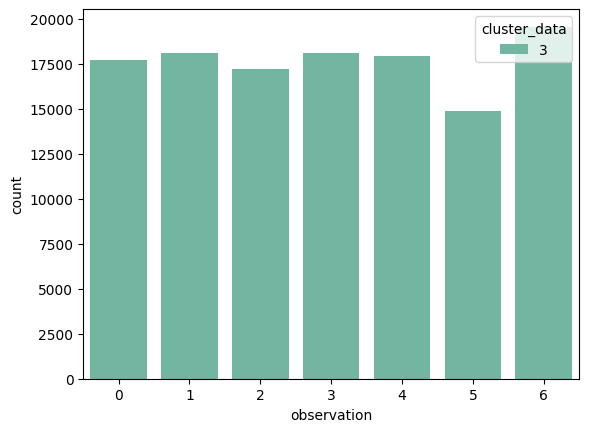

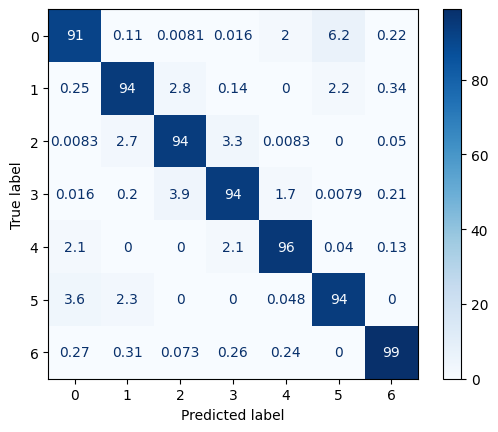

{'average_accuracy': 0.9404052695960745, 'average_f1_macro': 0.9390351367530928, 'average_f1_micro': 0.9404052695960745, 'average_auc': 0.997149691626174, 'average_acc_kelas_generatif': 0.9301770256554347, 'average_acc_fase_padi': 0.9367848638264663}
{'val_accuracy': 0.9466655875687925, 'val_f1_macro': 0.9454356977469143, 'val_f1_micro': 0.9466655875687925, 'val_auc': 0.9977862870381501, 'val_acc_kelas_generatif': 0.9393604421634426, 'val_acc_fase_padi': 0.9445144766592632, 'val_relative_acc': 99.92453336463801}
CLUSTER:  4


[I 2024-10-18 16:56:17,766] A new study created in memory with name: no-name-47afb520-856b-4de1-b88f-d43ef4af0a26


[1 2 6 3 4 0 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-18 16:57:08,965] Trial 0 finished with value: 0.821795768877649 and parameters: {'max_depth': 9, 'learning_rate': 0.030460726653898658, 'reg_lambda': 4.289338037762597, 'min_child_weight': 90}. Best is trial 0 with value: 0.821795768877649.


[I 2024-10-18 16:57:52,673] Trial 1 finished with value: 0.8223116302620749 and parameters: {'max_depth': 10, 'learning_rate': 0.04116025249196777, 'reg_lambda': 2.1996276883556978, 'min_child_weight': 75}. Best is trial 1 with value: 0.8223116302620749.


[I 2024-10-18 16:58:25,139] Trial 2 finished with value: 0.821124427492638 and parameters: {'max_depth': 6, 'learning_rate': 0.08015781600327698, 'reg_lambda': 2.5576577090867207, 'min_child_weight': 64}. Best is trial 1 with value: 0.8223116302620749.


[I 2024-10-18 16:59:56,154] Trial 3 finished with value: 0.8180927673016783 and parameters: {'max_depth': 7, 'learning_rate': 0.01098108963488098, 'reg_lambda': 2.4541414601629983, 'min_child_weight': 98}. Best is trial 1 with value: 0.8223116302620749.


[I 2024-10-18 17:00:24,164] Trial 4 finished with value: 0.8208214473341809 and parameters: {'max_depth': 7, 'learning_rate': 0.08676880720182105, 'reg_lambda': 2.9022357079024963, 'min_child_weight': 65}. Best is trial 1 with value: 0.8223116302620749.


[I 2024-10-18 17:01:21,339] Trial 5 finished with value: 0.8208785795184053 and parameters: {'max_depth': 10, 'learning_rate': 0.047948524591080545, 'reg_lambda': 0.8693860778198238, 'min_child_weight': 91}. Best is trial 1 with value: 0.8223116302620749.


[I 2024-10-18 17:02:07,843] Trial 6 finished with value: 0.8226548579469849 and parameters: {'max_depth': 10, 'learning_rate': 0.04130529979759143, 'reg_lambda': 1.5025190927039593, 'min_child_weight': 53}. Best is trial 6 with value: 0.8226548579469849.


[I 2024-10-18 17:02:35,359] Trial 7 finished with value: 0.8214011031630318 and parameters: {'max_depth': 10, 'learning_rate': 0.06008548566287295, 'reg_lambda': 4.055551677525037, 'min_child_weight': 85}. Best is trial 6 with value: 0.8226548579469849.


[I 2024-10-18 17:03:18,466] Trial 8 finished with value: 0.8211924563231613 and parameters: {'max_depth': 8, 'learning_rate': 0.038995896635835525, 'reg_lambda': 2.1681564297612774, 'min_child_weight': 91}. Best is trial 6 with value: 0.8226548579469849.


[I 2024-10-18 17:03:54,897] Trial 9 finished with value: 0.822089880654357 and parameters: {'max_depth': 9, 'learning_rate': 0.054444723854599364, 'reg_lambda': 0.9108194835981684, 'min_child_weight': 87}. Best is trial 6 with value: 0.8226548579469849.


[I 2024-10-18 17:04:21,525] Trial 10 finished with value: 0.8225200348667895 and parameters: {'max_depth': 9, 'learning_rate': 0.07052414169563676, 'reg_lambda': 0.3099000892153856, 'min_child_weight': 50}. Best is trial 6 with value: 0.8226548579469849.


[I 2024-10-18 17:04:50,027] Trial 11 finished with value: 0.8224800158679288 and parameters: {'max_depth': 9, 'learning_rate': 0.06911928091748927, 'reg_lambda': 0.32186086375640016, 'min_child_weight': 51}. Best is trial 6 with value: 0.8226548579469849.


[I 2024-10-18 17:06:05,601] Trial 12 finished with value: 0.8225461182586732 and parameters: {'max_depth': 9, 'learning_rate': 0.023584630079289244, 'reg_lambda': 1.3900552199378302, 'min_child_weight': 52}. Best is trial 6 with value: 0.8226548579469849.


[I 2024-10-18 17:07:29,804] Trial 13 finished with value: 0.8229079117275185 and parameters: {'max_depth': 8, 'learning_rate': 0.01977512550164093, 'reg_lambda': 1.4853323689326765, 'min_child_weight': 59}. Best is trial 13 with value: 0.8229079117275185.


[I 2024-10-18 17:09:09,494] Trial 14 finished with value: 0.820928043772757 and parameters: {'max_depth': 8, 'learning_rate': 0.011446609290940763, 'reg_lambda': 1.3213440093975506, 'min_child_weight': 62}. Best is trial 13 with value: 0.8229079117275185.


[I 2024-10-18 17:09:31,470] Trial 15 finished with value: 0.8216594031806194 and parameters: {'max_depth': 7, 'learning_rate': 0.09974947605415552, 'reg_lambda': 1.380504877505909, 'min_child_weight': 58}. Best is trial 13 with value: 0.8229079117275185.


[I 2024-10-18 17:10:41,222] Trial 16 finished with value: 0.821166436615474 and parameters: {'max_depth': 8, 'learning_rate': 0.027182647756400856, 'reg_lambda': 3.4067772294499417, 'min_child_weight': 72}. Best is trial 13 with value: 0.8229079117275185.


[I 2024-10-18 17:11:56,693] Trial 17 finished with value: 0.8207675679599088 and parameters: {'max_depth': 6, 'learning_rate': 0.02044158189886751, 'reg_lambda': 1.8075544291031722, 'min_child_weight': 71}. Best is trial 13 with value: 0.8229079117275185.


[I 2024-10-18 17:12:49,114] Trial 18 finished with value: 0.8233322785048142 and parameters: {'max_depth': 7, 'learning_rate': 0.03434545634478595, 'reg_lambda': 4.856016411066261, 'min_child_weight': 58}. Best is trial 18 with value: 0.8233322785048142.


[I 2024-10-18 17:13:46,283] Trial 19 finished with value: 0.8203691878232817 and parameters: {'max_depth': 7, 'learning_rate': 0.03084728188683735, 'reg_lambda': 4.997144583111341, 'min_child_weight': 79}. Best is trial 18 with value: 0.8233322785048142.


Best Parameters: {'max_depth': 7, 'learning_rate': 0.03434545634478595, 'reg_lambda': 4.856016411066261, 'min_child_weight': 58}
Best Score: 0.8233322785048142
Start the modelling


[0]	train-mlogloss:1.87377	eval-mlogloss:1.87482


[100]	train-mlogloss:0.44258	eval-mlogloss:0.54206


[200]	train-mlogloss:0.29836	eval-mlogloss:0.45595


[300]	train-mlogloss:0.23765	eval-mlogloss:0.43673


[400]	train-mlogloss:0.19190	eval-mlogloss:0.42904


[500]	train-mlogloss:0.15844	eval-mlogloss:0.42549


[600]	train-mlogloss:0.13368	eval-mlogloss:0.42481


[700]	train-mlogloss:0.11511	eval-mlogloss:0.42600


[800]	train-mlogloss:0.10006	eval-mlogloss:0.42759


[900]	train-mlogloss:0.08725	eval-mlogloss:0.42967


[1000]	train-mlogloss:0.07692	eval-mlogloss:0.43236


[1100]	train-mlogloss:0.06874	eval-mlogloss:0.43526


[1200]	train-mlogloss:0.06200	eval-mlogloss:0.43773


[1300]	train-mlogloss:0.05632	eval-mlogloss:0.44072


[1400]	train-mlogloss:0.05153	eval-mlogloss:0.44404


[1500]	train-mlogloss:0.04761	eval-mlogloss:0.44711


[1595]	train-mlogloss:0.04404	eval-mlogloss:0.45064


[0]	train-mlogloss:1.87329	eval-mlogloss:1.87398


[100]	train-mlogloss:0.44265	eval-mlogloss:0.54225


[200]	train-mlogloss:0.30433	eval-mlogloss:0.45651


[300]	train-mlogloss:0.23846	eval-mlogloss:0.43686


[400]	train-mlogloss:0.19345	eval-mlogloss:0.42880


[500]	train-mlogloss:0.16014	eval-mlogloss:0.42528


[600]	train-mlogloss:0.13391	eval-mlogloss:0.42460


[700]	train-mlogloss:0.11538	eval-mlogloss:0.42466


[800]	train-mlogloss:0.09978	eval-mlogloss:0.42541


[900]	train-mlogloss:0.08725	eval-mlogloss:0.42763


[1000]	train-mlogloss:0.07646	eval-mlogloss:0.43038


[1100]	train-mlogloss:0.06841	eval-mlogloss:0.43293


[1200]	train-mlogloss:0.06136	eval-mlogloss:0.43593


[1300]	train-mlogloss:0.05575	eval-mlogloss:0.43843


[1400]	train-mlogloss:0.05077	eval-mlogloss:0.44116


[1500]	train-mlogloss:0.04686	eval-mlogloss:0.44404


[1600]	train-mlogloss:0.04356	eval-mlogloss:0.44730


[1658]	train-mlogloss:0.04148	eval-mlogloss:0.44941


[0]	train-mlogloss:1.87309	eval-mlogloss:1.87446


[100]	train-mlogloss:0.43341	eval-mlogloss:0.55577


[200]	train-mlogloss:0.28858	eval-mlogloss:0.47275


[300]	train-mlogloss:0.22507	eval-mlogloss:0.45431


[400]	train-mlogloss:0.18170	eval-mlogloss:0.44615


[500]	train-mlogloss:0.15078	eval-mlogloss:0.44359


[600]	train-mlogloss:0.12841	eval-mlogloss:0.44451


[700]	train-mlogloss:0.10965	eval-mlogloss:0.44596


[800]	train-mlogloss:0.09483	eval-mlogloss:0.44883


[900]	train-mlogloss:0.08326	eval-mlogloss:0.45183


[1000]	train-mlogloss:0.07376	eval-mlogloss:0.45566


[1100]	train-mlogloss:0.06609	eval-mlogloss:0.45916


[1200]	train-mlogloss:0.05956	eval-mlogloss:0.46314


[1300]	train-mlogloss:0.05471	eval-mlogloss:0.46707


[1400]	train-mlogloss:0.05037	eval-mlogloss:0.47085


[1500]	train-mlogloss:0.04619	eval-mlogloss:0.47430


[1525]	train-mlogloss:0.04522	eval-mlogloss:0.47506


[0]	train-mlogloss:1.87263	eval-mlogloss:1.87286


[50]	train-mlogloss:0.69858	eval-mlogloss:0.73179


[100]	train-mlogloss:0.45843	eval-mlogloss:0.52591


[150]	train-mlogloss:0.36877	eval-mlogloss:0.46152


[200]	train-mlogloss:0.32211	eval-mlogloss:0.43644


[250]	train-mlogloss:0.28875	eval-mlogloss:0.42272


[300]	train-mlogloss:0.26354	eval-mlogloss:0.41480


[350]	train-mlogloss:0.24281	eval-mlogloss:0.40971


[400]	train-mlogloss:0.22504	eval-mlogloss:0.40615


[450]	train-mlogloss:0.20776	eval-mlogloss:0.40295


[500]	train-mlogloss:0.19322	eval-mlogloss:0.40066


[550]	train-mlogloss:0.18110	eval-mlogloss:0.39885


[600]	train-mlogloss:0.16872	eval-mlogloss:0.39742


[650]	train-mlogloss:0.15808	eval-mlogloss:0.39645


[700]	train-mlogloss:0.14752	eval-mlogloss:0.39573


[750]	train-mlogloss:0.13869	eval-mlogloss:0.39532


[800]	train-mlogloss:0.13051	eval-mlogloss:0.39513


[850]	train-mlogloss:0.12171	eval-mlogloss:0.39506


[883]	train-mlogloss:0.11696	eval-mlogloss:0.39522



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     11421
           1       0.90      0.94      0.92     11152
           2       0.85      0.81      0.83      6521
           3       0.95      0.95      0.95     11569
           4       0.93      0.95      0.94      9180
           5       0.72      0.65      0.68      5468
           6       0.68      0.64      0.66      6575

    accuracy                           0.86     61886
   macro avg       0.84      0.83      0.84     61886
weighted avg       0.86      0.86      0.86     61886



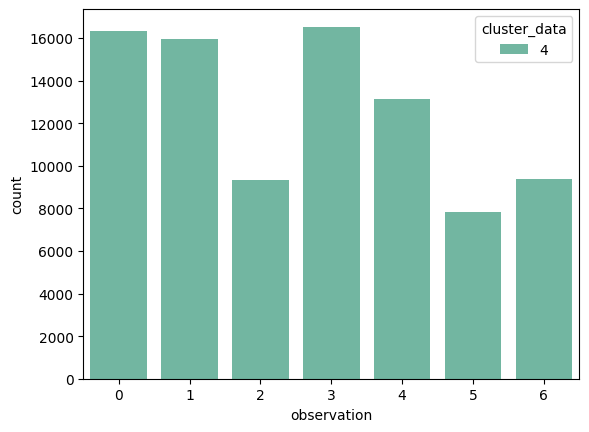

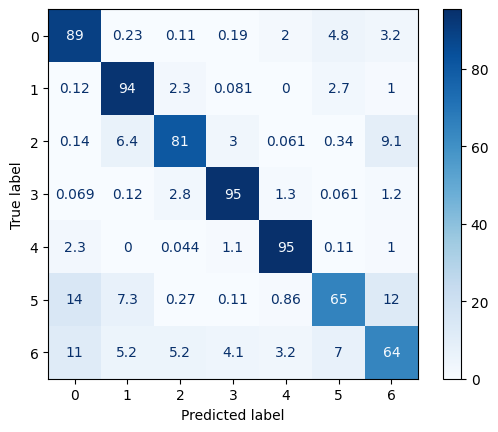

{'average_accuracy': 0.8514816390043441, 'average_f1_macro': 0.8221848088780684, 'average_f1_micro': 0.8514816390043441, 'average_auc': 0.9732416870431922, 'average_acc_kelas_generatif': 0.947357679216549, 'average_acc_fase_padi': 0.9152749022207326}
{'val_accuracy': 0.8625214103351323, 'val_f1_macro': 0.8353796582424476, 'val_f1_micro': 0.8625214103351323, 'val_auc': 0.9769273455778463, 'val_acc_kelas_generatif': 0.9452848128619586, 'val_acc_fase_padi': 0.9220498672635469, 'val_relative_acc': 99.80358398603263}


In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
dict_report={}
for i in np.sort(df.cluster_data.unique()):
    print('=============================================================================')
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_cluster_{i}.png", dpi=300, bbox_inches='tight')
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.7)
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Create an Optuna study and optimize the objective function
    print('Build Best Parameter using Optuna-Hyperparameter Tuning')
    study = optuna.create_study(direction='maximize')  # 'maximize' because we are optimizing accuracy
    study.optimize(lambda trial: objective(trial, X_train, y_train_encoded), n_trials=20)  # Run for 50 trials
    # Print the best parameters and the best score
    print(f"Best Parameters: {study.best_params}")
    print(f"Best Score: {study.best_value}")

    print('Start the modelling')
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded,cluster=i,best_params=study.best_params)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0,
                    'params':study.best_params}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)
    print('=============================================================================')




In [11]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl','wb') as file:
    pickle.dump(dict_report,file)